Analítica de datos en Big Data
===========
***Big Data II***

***Máster en Ciencia de Datos e Ingeniería de Computadores***

**Autor:** *Miguel Ángel Roldán Carmona*

**Correo:** *miguelroldanc@correo.ugr.es*

---

# Descripción del problema

El objetivo de esta práctica es resolver el problema de clasificación no balanceada asociado a un conjunto de datos muestreado de un problema Big Data que presenta 1 millón de instancias y está desbalanceado. 

Para ello, se utilizará la biblioteca Spark ML y los algoritmos disponibles en Spark Package mediante el lenguaje de programación Python. Podemos separar el problema en dos apartados:
- Aprendizaje. De la biblioteca MLlib se utilizarán los algoritmos Decision Tree, Random Forest y Logistic Regression. Además, se usará el algoritmo LightGBM.

- Preprocesamiento. Se utilizarán los algoritmos de preprocesamiento de "balanceo" de datos ROS, RUS proporcionados en el material de la asignatura y el algoritmo UnivariateFeatureSelector de SparkML para la selección de características.

---

# Creación de la sesión

In [1]:
import findspark
from pyspark.sql import SparkSession

findspark.init()
spark = SparkSession.builder \
    .master("local[8]") \
    .appName("Big Data Analytics") \
    .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.9.5") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

23/05/15 12:49:08 WARN Utils: Your hostname, miguel-HP-Notebook resolves to a loopback address: 127.0.1.1; using 192.168.1.35 instead (on interface wlo1)
23/05/15 12:49:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/home/miguel/.local/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/miguel/.ivy2/cache
The jars for the packages stored in: /home/miguel/.ivy2/jars
com.microsoft.azure#synapseml_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-b3f02de1-faf3-4fca-af30-c617ae545e50;1.0
	confs: [default]
	found com.microsoft.azure#synapseml_2.12;0.9.5 in central
	found com.microsoft.azure#synapseml-core_2.12;0.9.5 in central
	found org.scalactic#scalactic_2.12;3.0.5 in central
	found org.scala-lang#scala-reflect;2.12.4 in central
	found io.spray#spray-json_2.12;1.3.2 in central
	found com.jcraft#jsch;0.1.54 in central
	found org.apache.httpcomponents#httpclient;4.5.6 in central
	found org.apache.httpcomponents#httpcore;4.4.10 in central
	found commons-logging#commons-logging;1.2 in central
	found commons-codec#commons-codec;1.10 in central
	found org.apache.httpcomponents#httpmime;4.5.6 in central
	found com.linkedin.isolation-forest#isolation-forest_3.2.0_2.12;2.0.8 in central
	found com.chuusai#

23/05/15 13:08:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
spark

Mediante el enlace superior accedemos a la interfaz de la applicación generada

---

# Lectura de datos

In [2]:
# Leemos el conjunto de entrenamiento
dfTra = spark.read \
    .format("csv") \
    .option("inferSchema",True) \
    .option("header", False) \
    .load("susyMaster-Train.data")
dfTra.show(3)

# Leemos el conjunto de test 
dfTst = spark.read \
    .format("csv") \
    .option("inferSchema",True) \
    .option("header", False) \
    .load("susyMaster-Test.data")
dfTst.show(3)

+------------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+-------------------+------------------+--------------------+----+
|               _c0|                _c1|                _c2|               _c3|                _c4|                _c5|               _c6|                _c7|                _c8|                _c9|               _c10|              _c11|              _c12|               _c13|              _c14|               _c15|              _c16|                _c17|_c18|
+------------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+--

+------------------+-------------------+-------------------+------------------+--------------------+--------------------+-------------------+--------------------+-------------------+-------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+------------------+-------------------+----+
|               _c0|                _c1|                _c2|               _c3|                 _c4|                 _c5|                _c6|                 _c7|                _c8|                _c9|              _c10|              _c11|              _c12|               _c13|              _c14|               _c15|              _c16|               _c17|_c18|
+------------------+-------------------+-------------------+------------------+--------------------+--------------------+-------------------+--------------------+-------------------+-------------------+------------------+------------------+------------------+---------------

Una vez tenemos nuestros datos, vamos a ver como trabajar con ellos.

In [7]:
# Mostramos el tamaño del fichero de entrenamiento
print ("TRAIN: ", len(dfTra.columns), "variables y" , dfTra.count(), "instancias.")
# Mostramos el esquema y un resumen estadístico del fichero de entrenamiento
print ("Esquema de dfTra:")
dfTra.printSchema()
print ("Resumen estadístico dfTra:")
dfTra.describe().show()

# Mostramos el tamaño del fichero de test
print ("\nTEST: ", len(dfTst.columns), "variables y" , dfTst.count(), "instancias.")
# Mostramos el esquema y un resumen estadístico del fichero de test
print ("Esquema de dfTst:")
dfTst.printSchema()
print ("Resumen estadístico dfTst:")
dfTst.describe().show()

TRAIN:  19 variables y 1000000 instancias.
Esquema de dfTra:
root
 |-- _c0: double (nullable = true)
 |-- _c1: double (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: double (nullable = true)
 |-- _c5: double (nullable = true)
 |-- _c6: double (nullable = true)
 |-- _c7: double (nullable = true)
 |-- _c8: double (nullable = true)
 |-- _c9: double (nullable = true)
 |-- _c10: double (nullable = true)
 |-- _c11: double (nullable = true)
 |-- _c12: double (nullable = true)
 |-- _c13: double (nullable = true)
 |-- _c14: double (nullable = true)
 |-- _c15: double (nullable = true)
 |-- _c16: double (nullable = true)
 |-- _c17: double (nullable = true)
 |-- _c18: double (nullable = true)

Resumen estadístico dfTra:


+-------+-------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+--------------------+--------------------+------------------+--------------------+--------------------+-------------------+--------------------+-------------------+
|summary|                _c0|                 _c1|                 _c2|               _c3|                 _c4|                 _c5|                 _c6|                 _c7|                 _c8|                _c9|              _c10|                _c11|                _c12|              _c13|                _c14|                _c15|               _c16|                _c17|               _c18|
+-------+-------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------

+-------+-------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+--------------------+--------------------+------------------+--------------------+--------------------+-------------------+--------------------+------------------+
|summary|                _c0|                 _c1|                 _c2|               _c3|                _c4|                 _c5|                 _c6|                 _c7|                 _c8|                _c9|              _c10|                _c11|                _c12|              _c13|                _c14|                _c15|               _c16|                _c17|              _c18|
+-------+-------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------------

En los resultados anteriores podemos ver los siguientes aspectos:

* Tanto el conjunto de entrenamiento como el de test tienen 1M instancias.
* Ninguno de los dos conjuntos de datos presentan valores perdidos.

A continuación comprobamos la normalidad de los datos mediante el test de Kolmogórov-Smirnov.

In [ ]:
from pyspark.ml.stat import KolmogorovSmirnovTest
from pyspark.sql.functions import mean, stddev, col

# Comprobamos la normalidad para todas las columnas menos la última (clase)
for columna in dfTra.columns:
    stats = dfTra.select(mean(col(columna)).alias('mean'),
                    stddev(col(columna)).alias('std')
                    ).collect()
    media = stats[0]['mean']
    std = stats[0]['std']
    print(f"Media: {media}, stddev: {std}")
    ksResult = KolmogorovSmirnovTest.test(dfTra, columna, 'norm', media, std).first()
    print(f"Resultado para la columna {columna}: {round(ksResult.pValue, 3)}")

Media: 1.236635743632108, stddev: 0.7909204219196112


Resultado para la columna _c0: 0.0


Media: -0.0009921822759930922, stddev: 0.8915019721696861


Resultado para la columna _c1: 0.0


Media: -5.970842326889874e-05, stddev: 1.0011534138563305


Resultado para la columna _c2: 0.0


Media: 1.1130236375309228, stddev: 0.7287628543681426


Resultado para la columna _c3: 0.0


Media: -0.00034654006647226183, stddev: 0.9120933695464056


Resultado para la columna _c4: 0.0


Media: 0.0006710697601874803, stddev: 1.0017832223865155


Resultado para la columna _c5: 0.0


Media: 1.3400710312124031, stddev: 1.068355079660454


Resultado para la columna _c6: 0.0


Media: -0.0010219092455741531, stddev: 1.001041009124819


Resultado para la columna _c7: 0.0


Media: 1.2259560265280744, stddev: 1.0807900621852218


Resultado para la columna _c8: 0.0


Media: 0.06889122515156185, stddev: 1.318276577053306


Resultado para la columna _c9: 0.0


Media: 1.1490681244925856, stddev: 0.6606788670129351


Resultado para la columna _c10: 0.0


Media: 1.2193500361376046, stddev: 0.6773221329283439


Resultado para la columna _c11: 0.0


Media: 1.0465084275891683, stddev: 0.48617769250635845


Resultado para la columna _c12: 0.0


Media: 1.059756638342128, stddev: 0.9618735996707972


Resultado para la columna _c13: 0.0


Media: 1.1423351038568281, stddev: 0.6486774191625193


Resultado para la columna _c14: 0.0


Media: 1.1512317313764855, stddev: 0.6923020514452407


Resultado para la columna _c15: 0.0


Media: 1.012740180638274, stddev: 0.43022538591659876


Resultado para la columna _c16: 0.0


Media: 0.2715182669393291, stddev: 0.21640954171297377


Resultado para la columna _c17: 0.0


Media: 0.9, stddev: 0.30000015000011143


Resultado para la columna _c18: 0.0


Ninguna de las columnas tiene los valores normalizados, así que tendremos que añadirlo a los pasos del pipeline.

Por último, mostramos la distribución de la variable de salida (columna clase).

In [ ]:
dfTra.groupby(dfTra['_c18']).count().show()
dfTst.groupby(dfTst['_c18']).count().show()

+----+------+
|_c18| count|
+----+------+
| 0.0|100000|
| 1.0|900000|
+----+------+



+----+------+
|_c18| count|
+----+------+
| 0.0|100000|
| 1.0|900000|
+----+------+



Tanto el conjunto de entrenamiento como el conjunto de test están desbalanceados (1/9), lo que supone un problema a la hora de entrenar los modelos.

---

# Preprocesamiento

## RUS

In [3]:
import pyspark
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.regression import LabeledPoint

def RUS(train):
    if isinstance(train, pyspark.RDD):
        train_positive = train.filter(lambda lp: lp.label == 1)
        train_negative = train.filter(lambda lp: lp.label == 0)
        partitions = train.getNumPartitions()
    else:
        train_positive = train.where("label == 1")
        train_negative = train.where("label == 0")
        partitions = train.rdd.getNumPartitions()
    num_neg = float(train_negative.count())
    num_pos = float(train_positive.count())

    if num_pos > num_neg:
        fraction = num_neg / num_pos
        undersample = train_negative.union(train_positive.sample(False, fraction))
    else:
        fraction = num_pos / num_neg
        undersample = train_positive.union(train_negative.sample(False, fraction))

    return undersample.repartition(partitions)

## ROS

In [4]:
def ROS(train, overRate):
    if isinstance(train, pyspark.RDD):
        train_positive = train.filter(lambda lp: lp.label == 1)
        train_negative = train.filter(lambda lp: lp.label == 0)
        partitions = train.getNumPartitions()
    else:
        train_positive = train.where("label == 1")
        train_negative = train.where("label == 0")
        partitions = train.rdd.getNumPartitions()

    num_neg = float(train_negative.count())
    num_pos = float(train_positive.count())

    if num_pos > num_neg:
        fraction = (num_pos * overRate) / num_neg
        oversample = train_positive.union(train_negative.sample(True, fraction))
    else:
        fraction = (num_neg * overRate) / num_pos
        oversample = train_negative.union(train_positive.sample(True, fraction))

    return oversample.repartition(partitions)

## Funciones auxiliares

In [5]:
# Guardar los datos de un modelo en un diccionario
def append_model(models, name, result):
    models.append(
        {
            'modelo':name,
            'score':result
        }
    )

In [6]:
# Obtener la métrica TPRxTNR
from pyspark.mllib.evaluation import MulticlassMetrics

def get_evaluation(predictions):
    predandlabels = predictions.select("prediction", "label").rdd
    metrics = MulticlassMetrics(predandlabels)

    cm = metrics.confusionMatrix().toArray()
    tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    tpr = tp/(tp+fn)
    tnr = tn/(tn+fp)
    evangelion = tpr*tnr
    return evangelion

---
# Entrenamiento

## Preprocesamiento

In [7]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import RobustScaler

# Cambiamos la columna clase de Double a Integer
dfTra.withColumn('_c18', dfTra._c18.cast("Integer"))
dfTst.withColumn('_c18', dfTst._c18.cast("Integer"))
dfTra = dfTra.withColumnRenamed("_c18","label")
dfTst = dfTst.withColumnRenamed("_c18","label")

# Preprocesamos los datos para ser utilizados en un algoritmo de ML
# Unimos las variables de entrada con VectorAssembler
assembler = VectorAssembler(inputCols=dfTra.columns[:-1],outputCol="atributos")
# Normalizamos los atributos de entrada
scaler = RobustScaler(inputCol="atributos", outputCol='features', 
                      withScaling=True, withCentering=True,
                      lower=0.25, upper=0.75)

# Añadimos el preprocesamiento a una tubería
from pyspark.ml import Pipeline
etapas = [assembler,scaler]

In [8]:
modelos = []

In [9]:
# Creamos tuberias con cada modelo de entrenamiento
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from synapse.ml.lightgbm import *

lr = LogisticRegression(maxIter=10, regParam=0.01)
lr_pipe = Pipeline(stages=etapas + [lr])

dt = DecisionTreeClassifier(maxDepth=4)
dt_pipe = Pipeline(stages=etapas + [dt])

rt = RandomForestClassifier()
rt_pipe = Pipeline(stages=etapas + [rt])

lgbm = LightGBMClassifier(numIterations=10)
lgbm_pipe = Pipeline(stages=etapas + [lgbm])

## Modelos base

In [10]:
# Entrenamiento y prediccion de modelos base
modeloLR = lr_pipe.fit(dfTra)
prediccionesLR = modeloLR.transform(dfTst)
modeloDTree = dt_pipe.fit(dfTra)
prediccionesDTree = modeloDTree.transform(dfTst)
modeloRandF = rt_pipe.fit(dfTra)
prediccionesRandF = modeloRandF.transform(dfTst)
modeloLightgbm = lgbm_pipe.fit(dfTra)
prediccionesLight = modeloLightgbm.transform(dfTst)

# Evaluación de los modelos y calculo del TPR x TNR
eva_lr = get_evaluation(prediccionesLR)
append_model(modelos, 'LogisticRegression', eva_lr)
eva_dtree = get_evaluation(prediccionesDTree)
append_model(modelos, 'DecisionTrees', eva_dtree)
eva_randf = get_evaluation(prediccionesRandF)
append_model(modelos, 'RandomForest', eva_randf)
eva_light = get_evaluation(prediccionesLight)
append_model(modelos, 'LightGBM', eva_randf)

print(modelos)

23/05/15 13:11:18 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


/home/miguel/.local/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/home/miguel/.local/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[{'modelo': 'LogisticRegression', 'score': 0.000799960888888889}, {'modelo': 'DecisionTrees', 'score': 0.0}, {'modelo': 'RandomForest', 'score': 0.0}, {'modelo': 'LightGBM', 'score': 0.0}]


## Modelos con RUS

In [11]:
# Aplicamos Random Undersampling al conjunto de entrenamiento
dfTraRUS = RUS(dfTra)

# Entrenamiento y prediccion de modelos utilizando RUS
modeloLR = lr_pipe.fit(dfTraRUS)
prediccionesLR = modeloLR.transform(dfTst)
modeloDTree = dt_pipe.fit(dfTraRUS)
prediccionesDTree = modeloDTree.transform(dfTst)
modeloRandF = rt_pipe.fit(dfTraRUS)
prediccionesRandF = modeloRandF.transform(dfTst)
modeloLightgbm = lgbm_pipe.fit(dfTraRUS)
prediccionesLight = modeloLightgbm.transform(dfTst)

# Evaluación de los modelos y calculo del TPR x TNR
eva_lr = get_evaluation(prediccionesLR)
append_model(modelos, 'LogisticRegression_RUS', eva_lr)
eva_dtree = get_evaluation(prediccionesDTree)
append_model(modelos, 'DecisionTrees_RUS', eva_dtree)
eva_randf = get_evaluation(prediccionesRandF)
append_model(modelos, 'RandomForest_RUS', eva_randf)
eva_light = get_evaluation(prediccionesLight)
append_model(modelos, 'LightGBM_RUS', eva_randf)

print(modelos)

[{'modelo': 'LogisticRegression', 'score': 0.000799960888888889}, {'modelo': 'DecisionTrees', 'score': 0.0}, {'modelo': 'RandomForest', 'score': 0.0}, {'modelo': 'LightGBM', 'score': 0.0}, {'modelo': 'LogisticRegression_RUS', 'score': 0.595897232}, {'modelo': 'DecisionTrees_RUS', 'score': 0.5711190385}, {'modelo': 'RandomForest_RUS', 'score': 0.5867992923333334}, {'modelo': 'LightGBM_RUS', 'score': 0.5867992923333334}]


## Modelo con ROS

In [12]:
# Aplicamos Random Oversampling al conjunto de entrenamiento
dfTraROS = ROS(dfTra,0.8)

# Entrenamiento y prediccion de modelos utilizando ROS
modeloLR = lr_pipe.fit(dfTraROS)
prediccionesLR = modeloLR.transform(dfTst)
modeloDTree = dt_pipe.fit(dfTraROS)
prediccionesDTree = modeloDTree.transform(dfTst)
modeloRandF = rt_pipe.fit(dfTraROS)
prediccionesRandF = modeloRandF.transform(dfTst)
modeloLightgbm = lgbm_pipe.fit(dfTraROS)
prediccionesLight = modeloLightgbm.transform(dfTst)

# Evaluación de los modelos y calculo del TPR x TNR
eva_lr = get_evaluation(prediccionesLR)
append_model(modelos, 'LogisticRegression_ROS', eva_lr)
eva_dtree = get_evaluation(prediccionesDTree)
append_model(modelos, 'DecisionTrees_ROS', eva_dtree)
eva_randf = get_evaluation(prediccionesRandF)
append_model(modelos, 'RandomForest_ROS', eva_randf)
eva_light = get_evaluation(prediccionesLight)
append_model(modelos, 'LightGBM_ROS', eva_randf)

print(modelos)

23/05/15 13:19:38 WARN MemoryStore: Not enough space to cache rdd_1135_5 in memory! (computed 45.0 MiB so far)
23/05/15 13:19:38 WARN BlockManager: Persisting block rdd_1135_5 to disk instead.
23/05/15 13:19:38 WARN MemoryStore: Not enough space to cache rdd_1135_3 in memory! (computed 45.0 MiB so far)
23/05/15 13:19:38 WARN BlockManager: Persisting block rdd_1135_3 to disk instead.


[{'modelo': 'LogisticRegression', 'score': 0.000799960888888889}, {'modelo': 'DecisionTrees', 'score': 0.0}, {'modelo': 'RandomForest', 'score': 0.0}, {'modelo': 'LightGBM', 'score': 0.0}, {'modelo': 'LogisticRegression_RUS', 'score': 0.595897232}, {'modelo': 'DecisionTrees_RUS', 'score': 0.5711190385}, {'modelo': 'RandomForest_RUS', 'score': 0.5867992923333334}, {'modelo': 'LightGBM_RUS', 'score': 0.5867992923333334}, {'modelo': 'LogisticRegression_ROS', 'score': 0.6010302632666666}, {'modelo': 'DecisionTrees_ROS', 'score': 0.5765474765}, {'modelo': 'RandomForest_ROS', 'score': 0.5794295205555555}, {'modelo': 'LightGBM_ROS', 'score': 0.5794295205555555}]


## Preprocesamiento con selección de características

In [13]:
from pyspark.ml.feature import UnivariateFeatureSelector

# Unimos las variables de entrada con VectorAssembler
assembler = VectorAssembler(inputCols=dfTra.columns[:-1],outputCol="atributos")

# Seleccionamos las mejores características
selector = UnivariateFeatureSelector(featuresCol='atributos', outputCol='atributos_sel', selectionMode='fpr')
selector.setFeatureType("continuous") \
        .setLabelType('categorical')

# Normalizamos los atributos de entrada
scaler = RobustScaler(inputCol="atributos_sel", outputCol='features', 
                      withScaling=True, withCentering=True,
                      lower=0.25, upper=0.75)

# Añadimos el preprocesamiento a una tubería
from pyspark.ml import Pipeline
etapas = [assembler,selector,scaler]

In [14]:
lr = LogisticRegression(maxIter=10, regParam=0.01)
lr_pipe = Pipeline(stages=etapas + [lr])

dt = DecisionTreeClassifier(maxDepth=4)
dt_pipe = Pipeline(stages=etapas + [dt])

rt = RandomForestClassifier()
rt_pipe = Pipeline(stages=etapas + [rt])

lgbm = LightGBMClassifier(numIterations=10)
lgbm_pipe = Pipeline(stages=etapas + [lgbm])

Así obtenemos una tubería con selección de características para entrenar los modelos. Por otra parte, obtenemos las características seleccionadas.

In [27]:
import numpy as np

assembler = VectorAssembler(inputCols=dfTra.columns[:-1],outputCol="atributos")
vec_df = assembler.transform(dfTra)

selector = UnivariateFeatureSelector(featuresCol='atributos', outputCol='atributos_sel', selectionMode='fpr')
selector.setFeatureType("continuous") \
        .setLabelType('categorical')

modelo = selector.fit(vec_df)
np.array(dfTra.columns)[modelo.selectedFeatures]

array(['_c16', '_c0', '_c8', '_c17', '_c9', '_c10', '_c11', '_c3', '_c12',
       '_c13', '_c14', '_c6', '_c15'], dtype='<U5')

Se obtienen 13 características de las 18 posibles. De esta forma conseguimos reducir el tamaño del conjunto de entrenamiento en un **27.78%**.

## Modelo base con selección de características

In [15]:
#Entrenamiento y prediccion de modelos base con seleccion de características
modeloLR = lr_pipe.fit(dfTra)
prediccionesLR = modeloLR.transform(dfTst)
modeloDTree = dt_pipe.fit(dfTra)
prediccionesDTree = modeloDTree.transform(dfTst)
modeloRandF = rt_pipe.fit(dfTra)
prediccionesRandF = modeloRandF.transform(dfTst)
modeloLightgbm = lgbm_pipe.fit(dfTra)
prediccionesLight = modeloLightgbm.transform(dfTst)

#Evaluación de los modelos y calculo del TPR x TNR
eva_lr = get_evaluation(prediccionesLR)
append_model(modelos, 'LogisticRegression_FeatSel', eva_lr)
eva_dtree = get_evaluation(prediccionesDTree)
append_model(modelos, 'DecisionTrees_FeatSel', eva_dtree)
eva_randf = get_evaluation(prediccionesRandF)
append_model(modelos, 'RandomForest_FeatSel', eva_randf)
eva_light = get_evaluation(prediccionesLight)
append_model(modelos, 'LightGBM_FeatSel', eva_randf)

print(modelos)

[{'modelo': 'LogisticRegression', 'score': 0.000799960888888889}, {'modelo': 'DecisionTrees', 'score': 0.0}, {'modelo': 'RandomForest', 'score': 0.0}, {'modelo': 'LightGBM', 'score': 0.0}, {'modelo': 'LogisticRegression_RUS', 'score': 0.595897232}, {'modelo': 'DecisionTrees_RUS', 'score': 0.5711190385}, {'modelo': 'RandomForest_RUS', 'score': 0.5867992923333334}, {'modelo': 'LightGBM_RUS', 'score': 0.5867992923333334}, {'modelo': 'LogisticRegression_ROS', 'score': 0.6010302632666666}, {'modelo': 'DecisionTrees_ROS', 'score': 0.5765474765}, {'modelo': 'RandomForest_ROS', 'score': 0.5794295205555555}, {'modelo': 'LightGBM_ROS', 'score': 0.5794295205555555}, {'modelo': 'LogisticRegression_FeatSel', 'score': 0.0008099594999999999}, {'modelo': 'DecisionTrees_FeatSel', 'score': 0.0}, {'modelo': 'RandomForest_FeatSel', 'score': 0.0}, {'modelo': 'LightGBM_FeatSel', 'score': 0.0}]


## Modelo con RUS

In [16]:
# Conservamos el conjunto de datos dfTraRUS
# Entrenamiento y prediccion de modelos utilizando RUS
modeloLR = lr_pipe.fit(dfTraRUS)
prediccionesLR = modeloLR.transform(dfTst)
modeloDTree = dt_pipe.fit(dfTraRUS)
prediccionesDTree = modeloDTree.transform(dfTst)
modeloRandF = rt_pipe.fit(dfTraRUS)
prediccionesRandF = modeloRandF.transform(dfTst)
modeloLightgbm = lgbm_pipe.fit(dfTraRUS)
prediccionesLight = modeloLightgbm.transform(dfTst)

# Evaluación de los modelos y calculo del TPR x TNR
eva_lr = get_evaluation(prediccionesLR)
append_model(modelos, 'LogisticRegression_RUS_FeatSel', eva_lr)
eva_dtree = get_evaluation(prediccionesDTree)
append_model(modelos, 'DecisionTrees_RUS_FeatSel', eva_dtree)
eva_randf = get_evaluation(prediccionesRandF)
append_model(modelos, 'RandomForest_RUS_FeatSel', eva_randf)
eva_light = get_evaluation(prediccionesLight)
append_model(modelos, 'LightGBM_RUS_FeatSel', eva_randf)

print(modelos)

[{'modelo': 'LogisticRegression', 'score': 0.000799960888888889}, {'modelo': 'DecisionTrees', 'score': 0.0}, {'modelo': 'RandomForest', 'score': 0.0}, {'modelo': 'LightGBM', 'score': 0.0}, {'modelo': 'LogisticRegression_RUS', 'score': 0.595897232}, {'modelo': 'DecisionTrees_RUS', 'score': 0.5711190385}, {'modelo': 'RandomForest_RUS', 'score': 0.5867992923333334}, {'modelo': 'LightGBM_RUS', 'score': 0.5867992923333334}, {'modelo': 'LogisticRegression_ROS', 'score': 0.6010302632666666}, {'modelo': 'DecisionTrees_ROS', 'score': 0.5765474765}, {'modelo': 'RandomForest_ROS', 'score': 0.5794295205555555}, {'modelo': 'LightGBM_ROS', 'score': 0.5794295205555555}, {'modelo': 'LogisticRegression_FeatSel', 'score': 0.0008099594999999999}, {'modelo': 'DecisionTrees_FeatSel', 'score': 0.0}, {'modelo': 'RandomForest_FeatSel', 'score': 0.0}, {'modelo': 'LightGBM_FeatSel', 'score': 0.0}, {'modelo': 'LogisticRegression_RUS_FeatSel', 'score': 0.595848988}, {'modelo': 'DecisionTrees_RUS_FeatSel', 'score'

## Modelo con ROS

In [17]:
# Conservamos el conjunto de datos dfTraROS
# Entrenamiento y prediccion de modelos utilizando ROS
modeloLR = lr_pipe.fit(dfTraROS)
prediccionesLR = modeloLR.transform(dfTst)
modeloDTree = dt_pipe.fit(dfTraROS)
prediccionesDTree = modeloDTree.transform(dfTst)
modeloRandF = rt_pipe.fit(dfTraROS)
prediccionesRandF = modeloRandF.transform(dfTst)
modeloLightgbm = lgbm_pipe.fit(dfTraRUS)
prediccionesLight = modeloLightgbm.transform(dfTst)

# Evaluación de los modelos y calculo del TPR x TNR
eva_lr = get_evaluation(prediccionesLR)
append_model(modelos, 'LogisticRegression_ROS_FeatSel', eva_lr)
eva_dtree = get_evaluation(prediccionesDTree)
append_model(modelos, 'DecisionTrees_ROS_FeatSel', eva_dtree)
eva_randf = get_evaluation(prediccionesRandF)
append_model(modelos, 'RandomForest_ROS_FeatSel', eva_randf)
eva_light = get_evaluation(prediccionesLight)
append_model(modelos, 'LightGBM_ROS_FeatSel', eva_randf)

print(modelos)

23/05/15 13:35:46 WARN MemoryStore: Not enough space to cache rdd_2582_4 in memory! (computed 43.6 MiB so far)
23/05/15 13:35:46 WARN BlockManager: Persisting block rdd_2582_4 to disk instead.
23/05/15 13:35:46 WARN MemoryStore: Not enough space to cache rdd_2582_7 in memory! (computed 43.6 MiB so far)
23/05/15 13:35:46 WARN BlockManager: Persisting block rdd_2582_7 to disk instead.
23/05/15 13:35:46 WARN MemoryStore: Not enough space to cache rdd_2582_2 in memory! (computed 43.6 MiB so far)
23/05/15 13:35:46 WARN BlockManager: Persisting block rdd_2582_2 to disk instead.
23/05/15 13:35:46 WARN MemoryStore: Not enough space to cache rdd_2582_5 in memory! (computed 43.6 MiB so far)
23/05/15 13:35:46 WARN BlockManager: Persisting block rdd_2582_5 to disk instead.


[{'modelo': 'LogisticRegression', 'score': 0.000799960888888889}, {'modelo': 'DecisionTrees', 'score': 0.0}, {'modelo': 'RandomForest', 'score': 0.0}, {'modelo': 'LightGBM', 'score': 0.0}, {'modelo': 'LogisticRegression_RUS', 'score': 0.595897232}, {'modelo': 'DecisionTrees_RUS', 'score': 0.5711190385}, {'modelo': 'RandomForest_RUS', 'score': 0.5867992923333334}, {'modelo': 'LightGBM_RUS', 'score': 0.5867992923333334}, {'modelo': 'LogisticRegression_ROS', 'score': 0.6010302632666666}, {'modelo': 'DecisionTrees_ROS', 'score': 0.5765474765}, {'modelo': 'RandomForest_ROS', 'score': 0.5794295205555555}, {'modelo': 'LightGBM_ROS', 'score': 0.5794295205555555}, {'modelo': 'LogisticRegression_FeatSel', 'score': 0.0008099594999999999}, {'modelo': 'DecisionTrees_FeatSel', 'score': 0.0}, {'modelo': 'RandomForest_FeatSel', 'score': 0.0}, {'modelo': 'LightGBM_FeatSel', 'score': 0.0}, {'modelo': 'LogisticRegression_RUS_FeatSel', 'score': 0.595848988}, {'modelo': 'DecisionTrees_RUS_FeatSel', 'score'

# Resultados obtenidos

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

modelos = pd.DataFrame(modelos)
modelos.sort_values(by='score', ascending=False, inplace=True)
display(modelos)

,modelo,score
8,LogisticRegression_ROS,0.601030
20,LogisticRegression_ROS_FeatSel,0.600877
4,LogisticRegression_RUS,0.595897
16,LogisticRegression_RUS_FeatSel,0.595849
19,LightGBM_RUS_FeatSel,0.589189
18,RandomForest_RUS_FeatSel,0.589189
6,RandomForest_RUS,0.586799
7,LightGBM_RUS,0.586799
10,RandomForest_ROS,0.579430
11,LightGBM_ROS,0.579430


En la tabla anterior se representan las puntuaciones obtenidas para cada clasificador. Por la gran diferencia en el número de instancias, los modelos base (tanto los modelos con todas las características como los modelos que utilizan feature selection) se especializan en gran medida en el conjunto negativo o mayoritario y consiguen una puntuación muy baja para las instancias positivas.

Una vez que se aplican técnicas para balancear los conjuntos se consiguen resultados más prometedores. A continuación graficamos los resultados de los clasificadores que han obtenido una puntuación mayor a 0 para realizar un estudio sobre ellos.

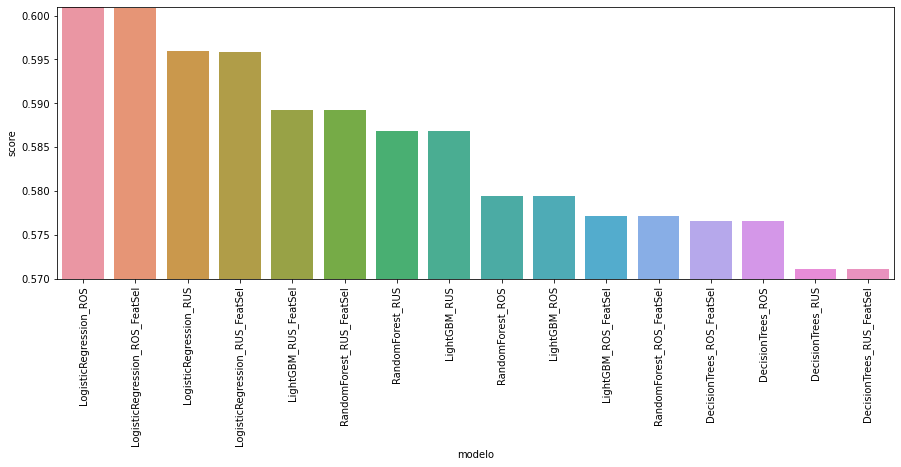

In [19]:
plt.figure(figsize=(15,5))
ax = sns.barplot(data=modelos.loc[modelos.score > 0.1], x='modelo', y='score')
labels = ax.get_xticklabels()
ax.set_xticklabels(labels=labels,rotation=90)
ax.set_ylim(0.57,0.601)
plt.show()

Los clasificadores basados en regresión logística son los que obtienen mejor puntuación para este problema, obteniendo para todos los clasificadores mejores puntuaciones que con el resto de modelos (RandomForest, DecisionTrees). En específico, el modelo basado en RandomOversampling es el que obtiene mejores resultados. 

La selección de características no modifica la puntuación de los clasificadores de forma significativa. Sin embargo, hemos visto que reduce el tamaño del conjunto de entrenamiento, lo que supone reducir el tiempo de entrenamiento. Por tanto, es un buen indicador y conservamos la selección de características para los modelos.

Por tanto, para este problema se debería seleccionar el modelo basado en regresión logística aplicando RandomUndersampling o RandomOversampling con selección de características. La elección de la técnica de balanceo se dejaría en manos del experto en el dominio del problema.